# Electricity forcasting for certain aggreigate

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Data.csv')
df.head()

,Date,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X22,X23,X24,X25,X26,X27,X28,X29,X30,Temperature
0,2013-01-01 00:00:00,0.1831,0.3236,0.1851,0.6686,0.0943,0.2840,0.2395,0.2236,0.2097,...,0.275585,0.262597,0.268870,0.250223,0.278281,0.256886,0.270291,0.259152,0.258059,9.44
1,2013-01-01 00:30:00,0.2275,0.2885,0.2693,0.5631,0.0769,0.2604,0.1940,0.2254,0.2117,...,0.255229,0.237143,0.246114,0.231734,0.256040,0.239540,0.246829,0.243501,0.235395,9.44
2,2013-01-01 01:00:00,0.1721,0.2475,0.1801,0.4796,0.0727,0.1948,0.1459,0.1650,0.1819,...,0.226284,0.216398,0.224992,0.208977,0.232676,0.219671,0.224743,0.221580,0.212552,9.44
3,2013-01-01 01:30:00,0.1484,0.2025,0.1510,0.3917,0.0665,0.1305,0.1306,0.1397,0.1885,...,0.217132,0.196036,0.207500,0.185838,0.209896,0.202164,0.199569,0.204574,0.189959,9.44
4,2013-01-01 02:00:00,0.1386,0.1454,0.1160,0.3392,0.0966,0.1045,0.1379,0.1290,0.1713,...,0.190914,0.177398,0.195067,0.171828,0.192228,0.184190,0.181472,0.191244,0.176519,9.44


## Data cleaning 

### checking null values 

In [3]:
df.isnull().sum()

Date             0
X1               0
X2               0
X3               0
X4               0
X5               0
X6               0
X7               0
X8               0
X9               0
X10              0
X11              0
X12              0
X13              0
X14              0
X15              0
X16              0
X17              0
X18              0
X19              0
X20              0
X21              0
X22              0
X23              0
X24              0
X25              0
X26              0
X27              0
X28              0
X29              0
X30              0
Temperature    104
dtype: int64

the data has no null values in the electrictiy data for all aggregates, However the temperture data has some null values.

## forcating the elctricity for the first aggregate 

### defining functions

In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
             
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
             
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [28]:
X1 = np.array(df['X1']*10)
time_step = df.index

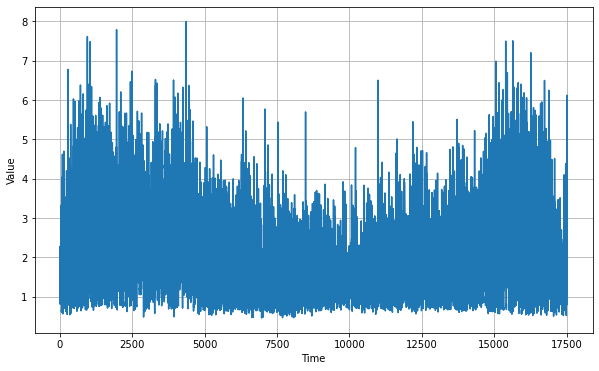

In [29]:
series = X1
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [30]:
split_time = 12000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

shuffle_buffer_size = 1000

In [31]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 8)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(12000,)
Epoch 1/100
47/47 [==============================] - 24s 404ms/step - loss: 1.3273 - mae: 1.8234
Epoch 2/100
47/47 [==============================] - 20s 412ms/step - loss: 1.3262 - mae: 1.8223
Epoch 3/100
47/47 [==============================] - 19s 403ms/step - loss: 1.3250 - mae: 1.8210
Epoch 4/100
47/47 [==============================] - 19s 401ms/step - loss: 1.3236 - mae: 1.8196
Epoch 5/100
47/47 [==============================] - 19s 402ms/step - loss: 1.3221 - mae: 1.8180
Epoch 6/100
47/47 [==============================] - 19s 402ms/step - loss: 1.3203 - mae: 1.8162
Epoch 7/100
47/47 [==============================] - 19s 403ms/step - loss: 1.3184 - mae: 1.8142
Epoch 8/100
47/47 [==============================] - 19s 403ms/step - loss: 1.3162 - mae: 1.8119
Epoch 9/100
47/47 [==============================] - 20s 414ms/step - loss: 1.3137 - mae: 1.8093
Epoch 10/100
47/47 [====

(1e-05, 0.001, 0.0, 0.4)

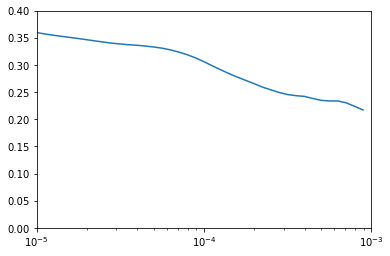

In [37]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1e-3, 0, 0.4])

In [38]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=64, batch_size=256, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 8)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=50)

Epoch 1/50
47/47 [==============================] - 31s 450ms/step - loss: 0.4613 - mae: 0.8134
Epoch 2/50
47/47 [==============================] - 22s 461ms/step - loss: 0.3348 - mae: 0.6766
Epoch 3/50
47/47 [==============================] - 21s 443ms/step - loss: 0.3131 - mae: 0.6480
Epoch 4/50
47/47 [==============================] - 21s 449ms/step - loss: 0.2899 - mae: 0.6178
Epoch 5/50
47/47 [==============================] - 21s 444ms/step - loss: 0.2741 - mae: 0.5953
Epoch 6/50
47/47 [==============================] - 21s 450ms/step - loss: 0.2592 - mae: 0.5736
Epoch 7/50
47/47 [==============================] - 21s 448ms/step - loss: 0.2483 - mae: 0.5575
Epoch 8/50
47/47 [==============================] - 21s 448ms/step - loss: 0.2413 - mae: 0.5458
Epoch 9/50
47/47 [==============================] - 21s 447ms/step - loss: 0.2367 - mae: 0.5391
Epoch 10/50
47/47 [==============================] - 21s 446ms/step - loss: 0.2333 - mae: 0.5342
Epoch 11/50
47/47 [====================

In [62]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]*0.1

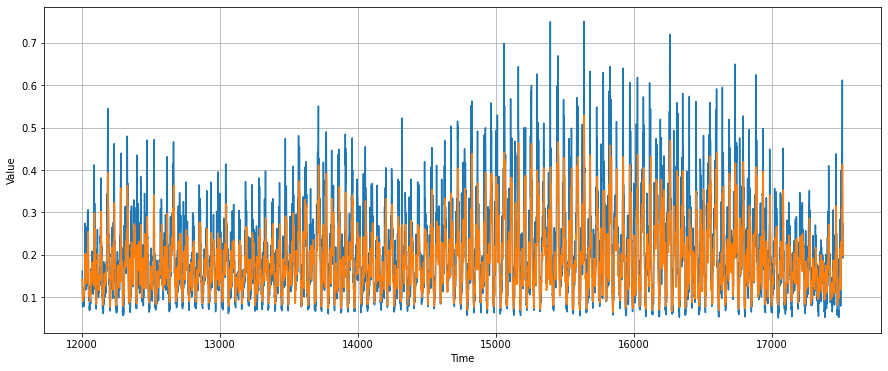

In [63]:
plt.figure(figsize=(15, 6))
plot_series(time_valid, x_valid*0.1)
plot_series(time_valid, rnn_forecast)

In [64]:
tf.keras.metrics.mean_absolute_error(x_valid * 0.1, rnn_forecast).numpy()

0.04482883

### prediction part 

In [65]:
s = series[len(series) - 480: len(series)] 
next_10_days_consumption = model_forecast(model, s[..., np.newaxis], 480) * 0.1
len(next_10_days_consumption)

1

In [66]:
time_exp = np.linspace(17520,18000,num = 480,dtype = int )

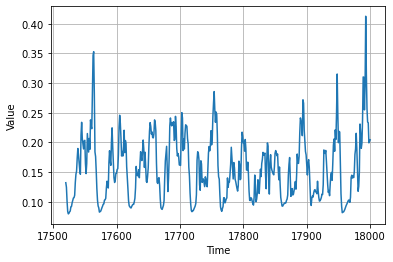

In [67]:
plot_series(time_exp, next_10_days_consumption[0])